This code explores the relationship between time to beaching and the following parameters: latitude, longitude, velocity magnitude, distance from shore, distance from gyres.

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [81]:
pip install geopy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 125 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 9.7 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [82]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import seaborn as sns
import random
import geopandas as gpd
from shapely.geometry import Point
from IPython.display import Image
import cartopy.crs as ccrs
import geopandas as gpd
from geopy.distance import geodesic

In [3]:
# loading drifter data files
metadata = pd.read_csv('drifter data/global drifter program/csv files/GDP_metadata.csv')
beach_drogued = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_drouged.csv')
beach_undrogued = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_undrouged.csv')
unbeach_drogued= pd.read_csv('GDP_NonRunAground_drouged-004.csv')
unbeach_undrogued = pd.read_csv('GDP_NonRunAground_undrouged-006.csv')

## 1. Let's start by adding 'time to beach' as an additional column in each drifter file

Let's start by finding the last values for each unique ID, this way we'll have its last 'time' before it beaches, letting us find time to beach

In [4]:
# get the last time values of beached
beach_drogued_last = beach_drogued.drop_duplicates(subset='ID', keep='last') 
beach_undrogued_last = beach_undrogued.drop_duplicates(subset='ID', keep='last')

The following function takes in the beaching dataframe, the last value for each ID dataframe, and a third parameter that is a time value, letting us assume that it takes a week for a 'beached' drifter to actually beach

In [7]:
def find_time_to_beach(beach, beach_last,beaching_timing):
    # DF to Numpy Arrays
    beach_array = beach.to_numpy()
    beach_last_array = beach_last.to_numpy()

    # Create a dictionary to store the last known time for each ID
    last_time_dict = dict(zip(beach_last_array[:, 0], beach_last_array[:, 5]))

    beach_time = []

    # Iterate through beach array and calculate time differences
    for row in beach_array:
        current_ID = row[0]
        last_time = last_time_dict.get(current_ID, None)
        
        if last_time is not None:
            current_time = row[5]
            if current_time != last_time: # prevent 0 value --> infinite time as beach_last exists within beach
                time_difference = last_time - current_time
                beach_time.append(time_difference)
            if current_time == last_time: # keep lat, lon, and values for hist shape the same
                beach_time.append(time_between_register_beaching_and_actually_beaching)

    return beach_time

Now let's calculate the time it takes to beach for every row

In [16]:
beaching_timing = 604800 # 1 week to actually beaching (?)
beach_drogued_time = np.array(find_time_to_beach(beach_drogued,beach_drogued_last, beaching_timing))
beach_undrogued_time = np.array(find_time_to_beach(beach_undrogued,beach_undrogued_last, beaching_timing))

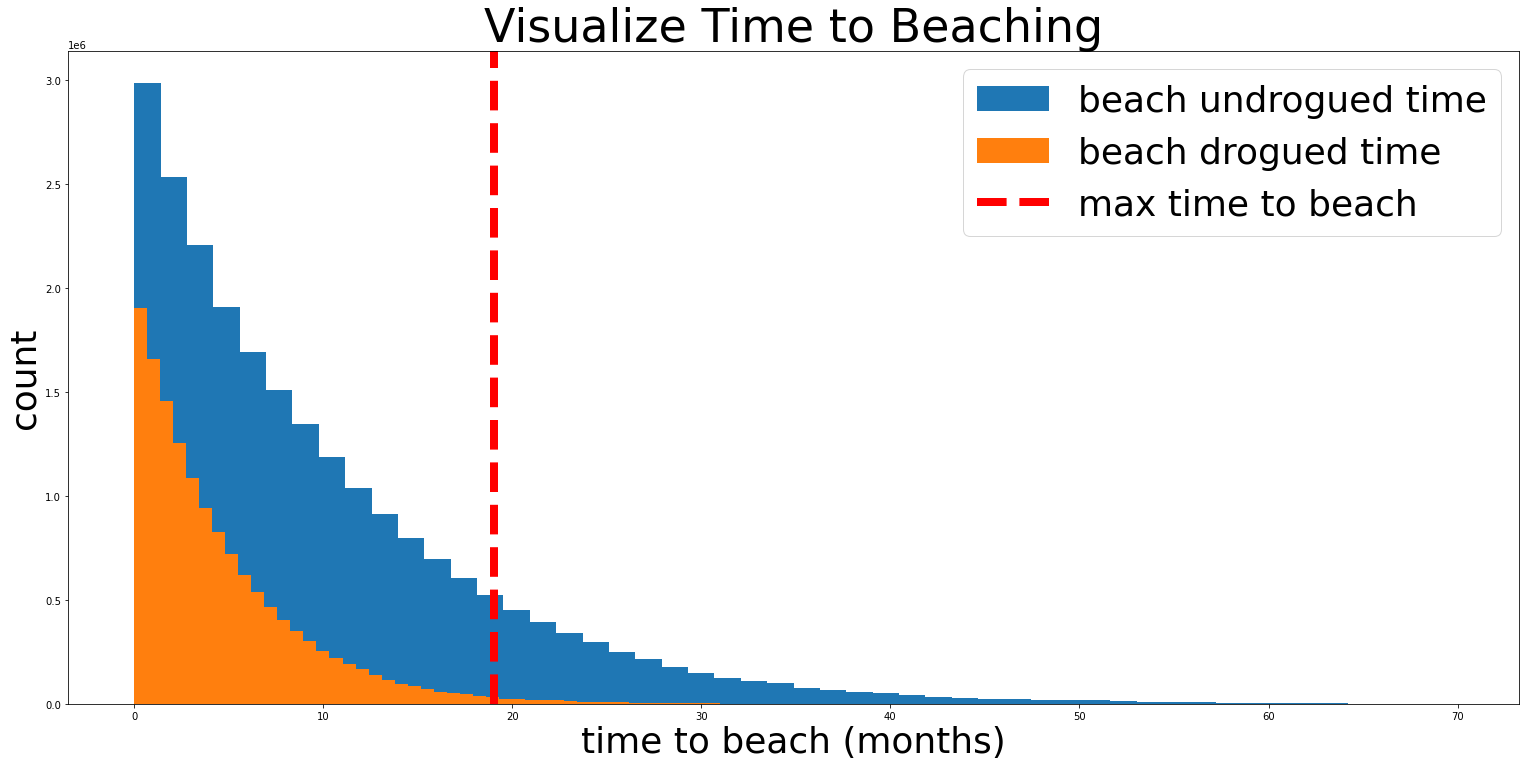

In [18]:
fig = plt.figure(figsize=(26, 12))
plt.hist(beach_undrogued_time / (2.628*10**6), label = 'beach undrogued time',bins = 50)
plt.hist(beach_drogued_time / (2.628*10**6), label = 'beach drogued time',bins = 50)
plt.title('Visualize Time to Beaching', fontsize = 46)
plt.xlabel('time to beach (months)',fontsize=36)
plt.ylabel('count', fontsize = 36)
plt.axvline(x=(0.5*10**8) / (2.628*10**6), color='r', linestyle='--', label='max time to beach',linewidth = 8)
plt.legend(fontsize = 36)

It appears as though most drifters will beach within 

In [17]:
# set time values as 1 / time
beach_drogued_time_inv = 1 / (beach_drogued_time)
beach_undrogued_time_inv = 1 / (beach_undrogued_time)

In [20]:
unbeach_undrogued_values = np.zeros(len(unbeach_undrogued))
unbeach_drogued_values = np.zeros(len(unbeach_drogued))

# take the inverse of values in order to set unbeached 0 values to infinity and return time values back to original
beach_drogued_time = 1 / beach_drogued_time_inv

beach_undrogued_time = 1 / beach_undrogued_time_inv

unbeach_drogued_time = 1 / unbeach_drogued_values

unbeach_undrogued_time = 1 / unbeach_undrogued_values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [21]:
# set max time_to_beach i.e, if a value is greater than max or infinity, we set it to the max
max_time_to_beach = 0.5*10**8

beach_drogued_time[beach_drogued_time == np.inf] = max_time_to_beach
beach_drogued_time[beach_drogued_time > max_time_to_beach] = max_time_to_beach

beach_undrogued_time[beach_undrogued_time == np.inf] = max_time_to_beach
beach_undrogued_time[beach_undrogued_time > max_time_to_beach] = max_time_to_beach

unbeach_drogued_time[unbeach_drogued_time == np.inf] = max_time_to_beach
unbeach_drogued_time[unbeach_drogued_time > max_time_to_beach] = max_time_to_beach

unbeach_undrogued_time[unbeach_undrogued_time == np.inf] = max_time_to_beach
unbeach_undrogued_time[unbeach_undrogued_time > max_time_to_beach] = max_time_to_beach

In [22]:
# reset time scale from seconds to months
beach_drogued_month = beach_drogued_time / (2.628*10**6)

beach_undrogued_month = beach_undrogued_time / (2.628*10**6)

unbeach_drogued_month = unbeach_drogued_time / (2.628*10**6)

unbeach_undrogued_month = unbeach_undrogued_time / (2.628*10**6)

In [23]:
# Adding the month arrays as new columns at the end of the existing dataframes
beach_drogued['time to beach'] = np.array(beach_drogued_month)

beach_undrogued['time to beach'] = np.array(beach_undrogued_month)

unbeach_drogued['time to beach'] = np.array(unbeach_drogued_month)

unbeach_undrogued['time to beach'] = np.array(unbeach_undrogued_month)

## 2. Now, let's explore the relationship between latitude, longitude and time to beach for the beached drifters

In [24]:
# define dataframes only containing the starting locations of drifters
first_beach_drogued = beach_drogued.drop_duplicates(subset='ID', keep='first')
first_beach_undrogued = beach_undrogued.drop_duplicates(subset='ID', keep='first')

### latitude

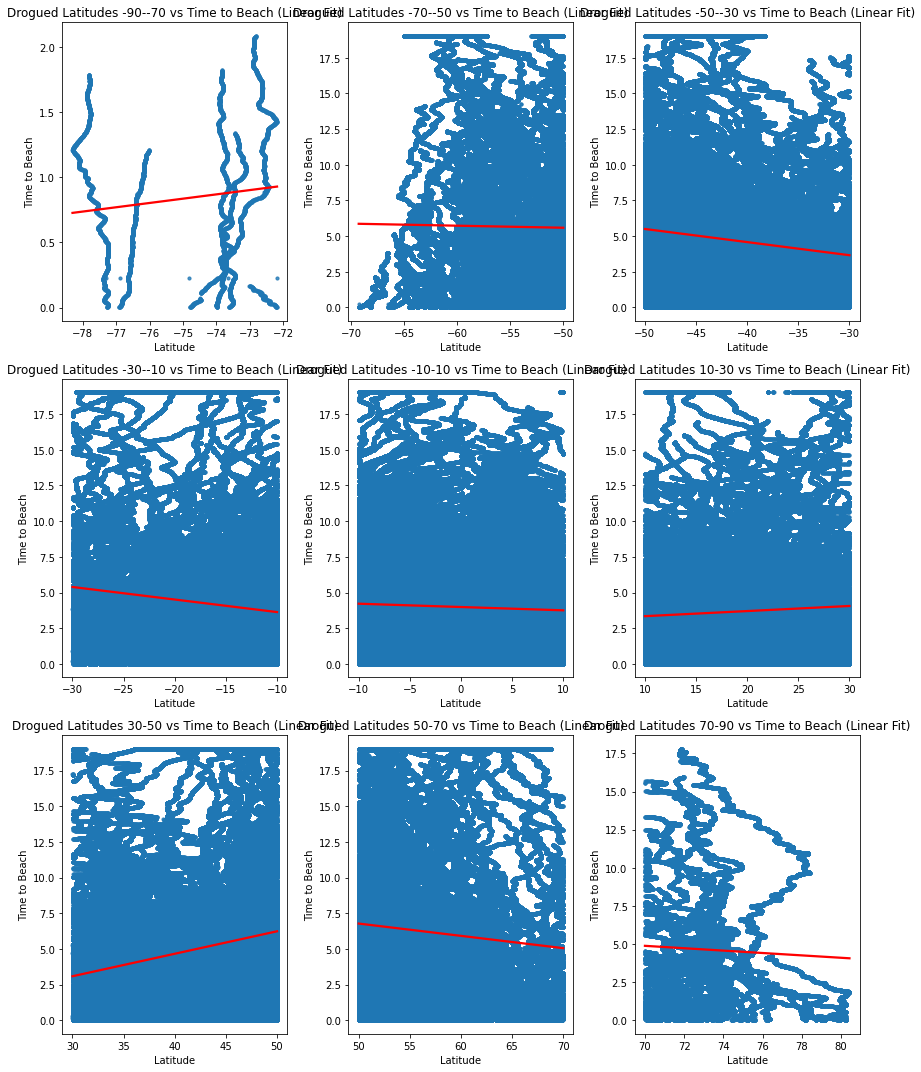

In [33]:
fig, axs = plt.subplots(3, 3, figsize=(12, 15))

# Plotting linear fits for 20-degree latitude intervals
for i, ax in enumerate(axs.flatten()):
    lower_bound = -90 + (i * 20)
    upper_bound = -90 + ((i + 1) * 20)
    subset = beach_drogued[(beach_drogued['lat'] >= lower_bound) & (beach_drogued['lat'] < upper_bound)]
    sns.regplot(x='lat', y='time to beach', data=subset, ci=None, scatter_kws={"s": 10}, line_kws={"color": "red"}, ax=ax)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Time to Beach')
    ax.set_title(f'Drogued Latitudes {lower_bound}-{upper_bound} vs Time to Beach (Linear Fit)')

plt.tight_layout()
plt.show()

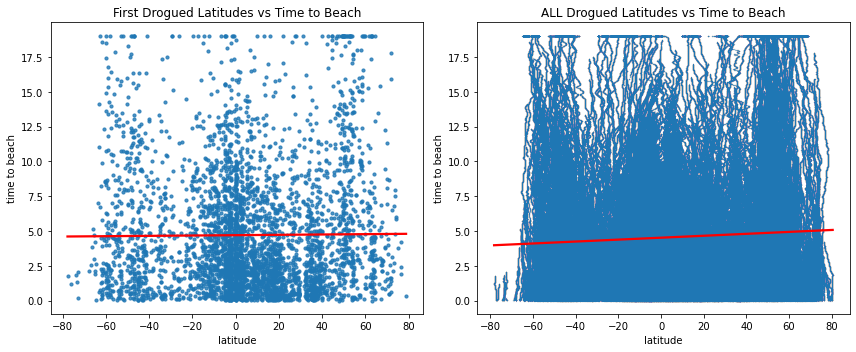

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x='lat', y='time to beach', data=first_beach_drogued, ci=None, scatter_kws={"s": 10},line_kws={"color": "red"}, ax = axs[0])
axs[0].set_xlabel('latitude')
axs[0].set_ylabel('time to beach')
axs[0].set_title('First Drogued Latitudes vs Time to Beach')

sns.regplot(x='lat', y='time to beach', data=beach_drogued, ci=None, scatter_kws={"s": 0.0005},line_kws={"color": "red"}, ax = axs[1])
axs[1].set_xlabel('latitude')
axs[1].set_ylabel('time to beach')
axs[1].set_title('ALL Drogued Latitudes vs Time to Beach')

plt.tight_layout()

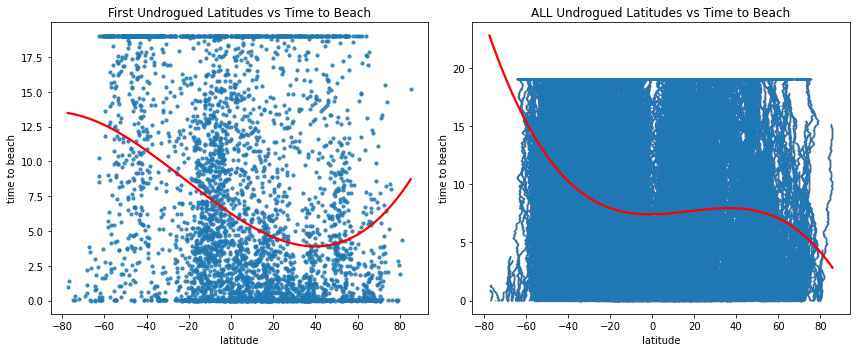

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x='lat', y='time to beach', data=first_beach_undrogued, order = 3, ci=None, scatter_kws={"s": 10},line_kws={"color": "red"}, ax = axs[0])
axs[0].set_xlabel('latitude')
axs[0].set_ylabel('time to beach')
axs[0].set_title('First Undrogued Latitudes vs Time to Beach')

sns.regplot(x='lat', y='time to beach', data=beach_undrogued, order = 3, ci=None, scatter_kws={"s": 0.0005},line_kws={"color": "red"}, ax = axs[1])
axs[1].set_xlabel('latitude')
axs[1].set_ylabel('time to beach')
axs[1].set_title('ALL Undrogued Latitudes vs Time to Beach')

plt.tight_layout()

### longitude 

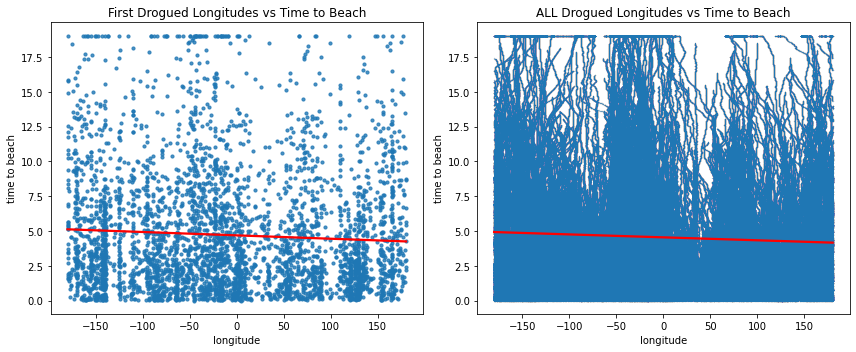

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x='lon', y='time to beach', data=first_beach_drogued, ci=None, scatter_kws={"s": 10},line_kws={"color": "red"}, ax = axs[0])
axs[0].set_xlabel('longitude')
axs[0].set_ylabel('time to beach')
axs[0].set_title('First Drogued Longitudes vs Time to Beach')

sns.regplot(x='lon', y='time to beach', data=beach_drogued, ci=None, scatter_kws={"s": 0.0005},line_kws={"color": "red"}, ax = axs[1])
axs[1].set_xlabel('longitude')
axs[1].set_ylabel('time to beach')
axs[1].set_title('ALL Drogued Longitudes vs Time to Beach')

plt.tight_layout()

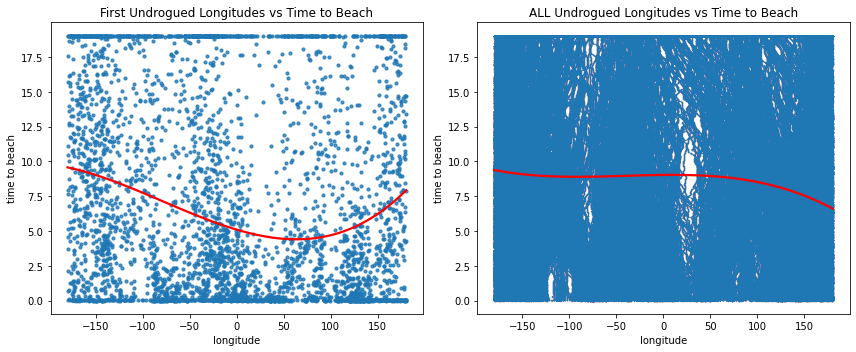

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x='lon', y='time to beach', data=first_beach_undrogued, order = 3, ci=None, scatter_kws={"s": 10},line_kws={"color": "red"}, ax = axs[0])
axs[0].set_xlabel('longitude')
axs[0].set_ylabel('time to beach')
axs[0].set_title('First Undrogued Longitudes vs Time to Beach')

sns.regplot(x='lon', y='time to beach', data=beach_undrogued, order = 3, ci=None, scatter_kws={"s": 0.0005},line_kws={"color": "red"}, ax = axs[1])
axs[1].set_xlabel('longitude')
axs[1].set_ylabel('time to beach')
axs[1].set_title('ALL Undrogued Longitudes vs Time to Beach')

plt.tight_layout()

### There doesn't seem to be a significant linear relationship between latitude and longitude or the time to beach

## 3. Now, let's explore the relationship between velocity magnitude and time to beach

### Let's first explore the spread of all velocities. Note that we're going to use cleaned data to ignore extreme outliers

In [30]:
# calculate velocity magnitude from north-south and east-west components and append to existing dataframe as new column
beach_drogued_vel = np.sqrt((beach_drogued['ve'])**2 + (beach_drogued['vn'])**2)
beach_drogued['vel mag'] = np.array(beach_drogued_vel)

beach_undrogued_vel = np.sqrt((beach_undrogued['ve'])**2 + (beach_undrogued['vn'])**2)
beach_undrogued['vel mag'] = np.array(beach_undrogued_vel)

unbeach_drogued_vel = np.sqrt((unbeach_drogued['ve'])**2 + (unbeach_drogued['vn'])**2)
unbeach_drogued['vel mag'] = np.array(unbeach_drogued_vel)

unbeach_undrogued_vel = np.sqrt((unbeach_undrogued['ve'])**2 + (unbeach_undrogued['vn'])**2)
unbeach_undrogued['vel mag'] = np.array(unbeach_undrogued_vel)

In [48]:
# let's clean the velocities of extreme outliers
unbeach_drogued_cleaned = unbeach_drogued[(unbeach_drogued['vel mag'] <= 1)]

unbeach_undrogued_cleaned = unbeach_undrogued[(unbeach_undrogued['vel mag'] <= 1)]

beach_drogued_cleaned = beach_drogued[(beach_drogued['vel mag'] <= 1)]

beach_undrogued_cleaned = beach_undrogued[(beach_undrogued['vel mag'] <= 1)]

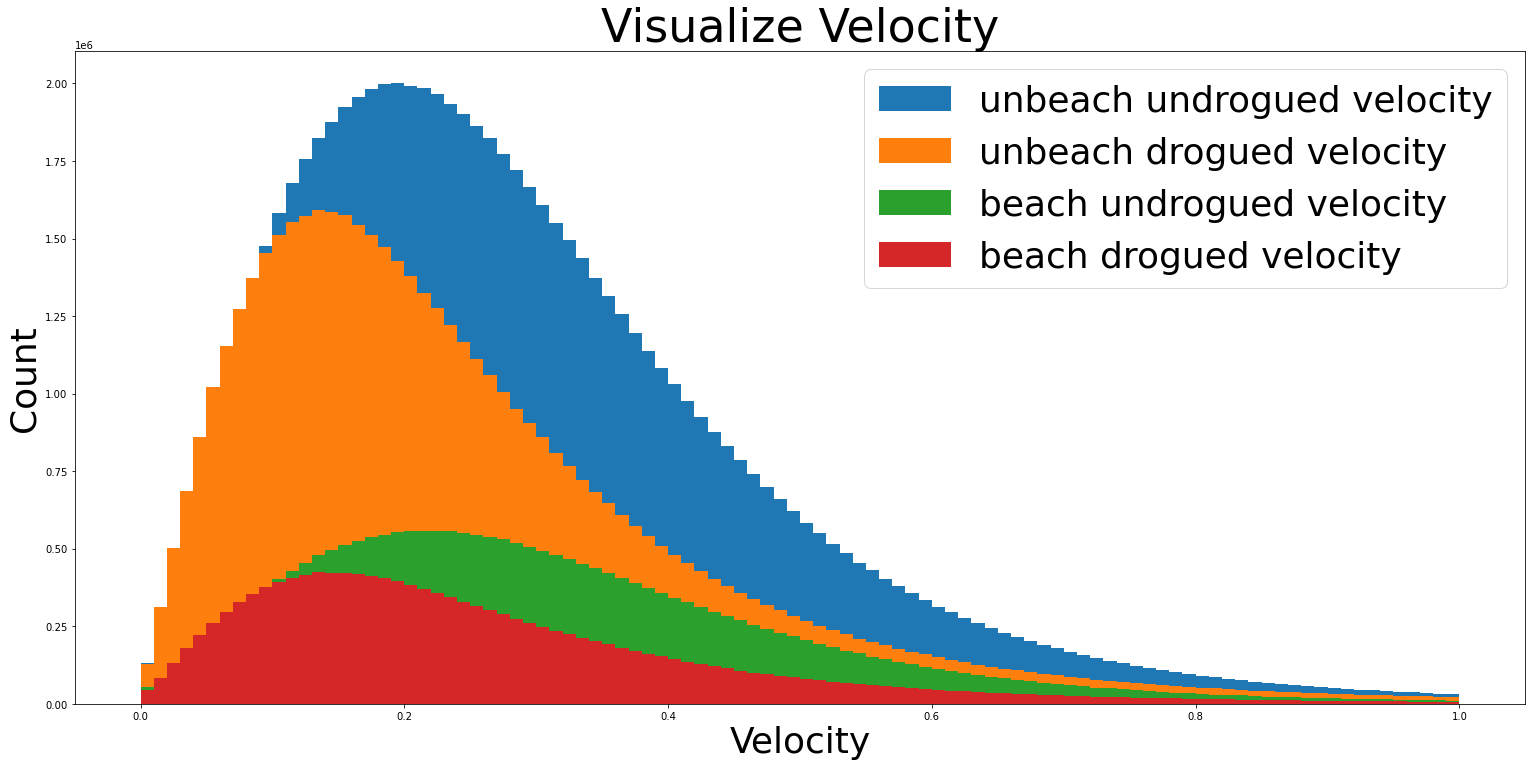

In [53]:
fig = plt.figure(figsize=(26, 12))
plt.hist(unbeach_undrogued_cleaned['vel mag'], label = 'unbeach undrogued velocity',bins = 100)
plt.hist(unbeach_drogued_cleaned['vel mag'], label = 'unbeach drogued velocity',bins = 100)
plt.hist(beach_undrogued_cleaned['vel mag'], label = 'beach undrogued velocity',bins = 100)
plt.hist(beach_drogued_cleaned['vel mag'], label = 'beach drogued velocity',bins = 100)

plt.title('Visualize Velocity', fontsize = 46)
plt.xlabel('Velocity',fontsize=36)
plt.ylabel('Count', fontsize = 36)
#plt.axvline(x=(0.5*10**8) / (2.628*10**6), color='r', linestyle='--', label='max time to beach',linewidth = 8)
plt.legend(fontsize = 36)

#### Now let's explore the relationship between velocity and time to beach

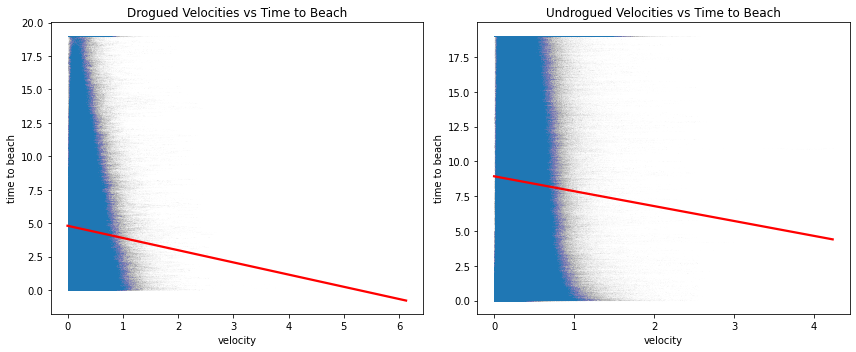

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x='vel mag', y='time to beach', data=beach_drogued, ci=None, scatter_kws={"s":  0.000005},line_kws={"color": "red"}, ax = axs[0])
axs[0].set_xlabel('velocity')
axs[0].set_ylabel('time to beach')
axs[0].set_title('Drogued Velocities vs Time to Beach')

sns.regplot(x='vel mag', y='time to beach', data=beach_undrogued, ci=None, scatter_kws={"s": 0.000005},line_kws={"color": "red"}, ax = axs[1])
axs[1].set_xlabel('velocity')
axs[1].set_ylabel('time to beach')
axs[1].set_title('Undrogued Velocities vs Time to Beach')

plt.tight_layout()

There appear to be some outliers, let's get rid of them and see if this changes the plot at all

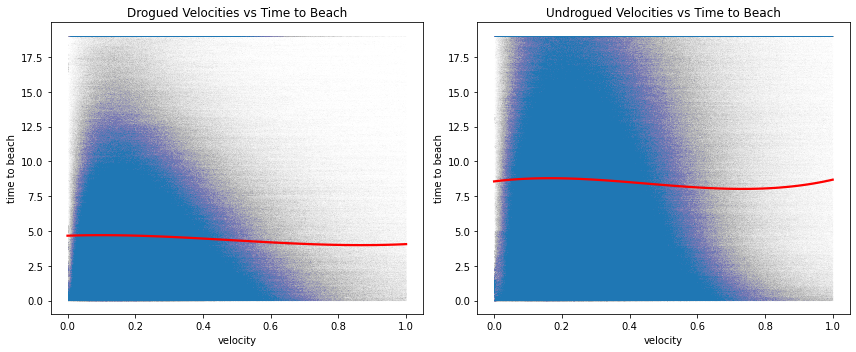

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.regplot(x='vel mag', y='time to beach', data=beach_drogued_cleaned, order = 3, ci=None, scatter_kws={"s":  0.000005},line_kws={"color": "red"}, ax = axs[0])
axs[0].set_xlabel('velocity')
axs[0].set_ylabel('time to beach')
axs[0].set_title('Drogued Velocities vs Time to Beach')

sns.regplot(x='vel mag', y='time to beach', data=beach_undrogued_cleaned, order = 3, ci=None, scatter_kws={"s": 0.000005},line_kws={"color": "red"}, ax = axs[1])
axs[1].set_xlabel('velocity')
axs[1].set_ylabel('time to beach')
axs[1].set_title('Undrogued Velocities vs Time to Beach')

plt.tight_layout()

### There doesn't appear to be a significant relationship between velocity and time to beach

## 4. Now, let's explore the relationship between Euclidian distance to gyres and time to beach

#### Let's first visualize where the main gyres are

In [71]:
# Rough coordinates of the center of the ocean's 5 main gyres
gyres = {
    'North Pacific': [30, -145],
    'South Pacific': [-30, -130],
    'North Atlantic': [30, -60],
    'South Atlantic': [-30, 0],
    'Indian': [-20, 80]
}

In [97]:
for gyre, coords in gyres.items():
    latitude, longitude = coords
    print(coords)

[30, -145]
[-30, -130]
[30, -60]
[-30, 0]
[-20, 80]


### Let's plot a heatmap of time to beach AND show where the main 5 gyres are with large red dots

In [67]:
# this block of code gets all the values in the right order and type for plotting
# get lats and lons separated and assign 0 to those that do not beach
beach_drogued_lats = np.array(beach_drogued['lat'])
beach_drogued_longs = np.array(beach_drogued['lon'])

beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

unbeach_drogued_lats = np.array(unbeach_drogued['lat'])
unbeach_drogued_longs = np.array(unbeach_drogued['lon'])

unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# concatenate all together into lats, longs variables for plotting
lats = np.concatenate((beach_drogued_lats, beach_undrogued_lats, unbeach_drogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_drogued_longs, beach_undrogued_longs, unbeach_drogued_longs, unbeach_undrogued_longs))

# concatenate both time to beaching and both unbeach 0 values
values = np.concatenate((beach_drogued_time_inv, beach_undrogued_time_inv, unbeach_drogued_values, unbeach_undrogued_values))
# take the inverse of values in order to set unbeached 0 values to infinity and return time values back to original
values_inv = 1 / values

# set max time_to_beach i.e, if a value is greater than max or infinity, we set it to the max
max_time_to_beach = 0.5*10**8
values_inv[values_inv == np.inf] = max_time_to_beach
values_inv[values_inv > max_time_to_beach] = max_time_to_beach

# set time scale from seconds to months
values_inv_month = values_inv / (2.628*10**6)

n_lons, n_lats = 720, 360 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)
statistic, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(longs,lats,values=values_inv_month,bins = [lon_bins,lat_bins])


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


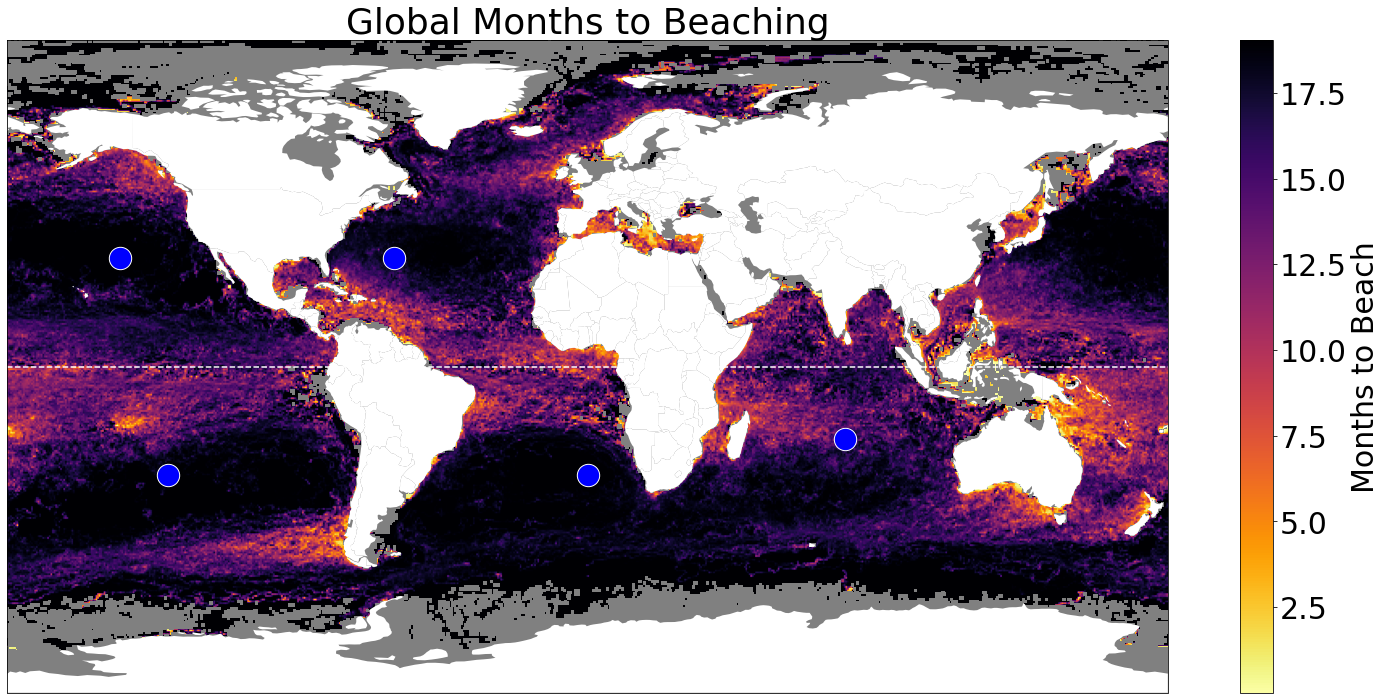

In [74]:
# this code block plots it all
# Given location, time to beaching

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno_r").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(statistic.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

plt.colorbar(label='Months to Beach')

# Plotting gyre centers as blue dots
for gyre, coords in gyres.items():
    plt.scatter(coords[1], coords[0], s=500, color='blue', edgecolor='white', label=gyre)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

ax.set_aspect('auto')
plt.title('Global Months to Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')
#plt.legend(loc='upper right')
plt.show()

#### This plot, excepting the Indian Ocean Gyre, suggests that there should be a relationship between euclidian distance to gyre and time to beach, with longer time to beach the closer a drifter is to a gyre

#### Let's calculate the euclidian distance between every drifter and the closest gyre

In [84]:
beach_drogued

,ID,lat,lon,ve,vn,time,time to beach,vel mag
0,101509,10.01950,136.335663,-0.1005,0.0952,1323990000,2.695890,0.138432
1,101509,10.02242,136.332306,-0.0956,0.0941,1323993600,2.694521,0.134142
2,101509,10.02558,136.329834,-0.1227,0.1313,1323997200,2.693151,0.179708
3,101509,10.03013,136.325272,-0.1216,0.1332,1324000800,2.691781,0.180357
4,101509,10.03423,136.321274,-0.1219,0.1329,1324004400,2.690411,0.180339
...,...,...,...,...,...,...,...,...
14265860,9917894,-12.49475,172.784973,-0.1337,0.0368,970772400,0.005479,0.138672
14265861,9917894,-12.49576,172.779144,-0.1448,0.0301,970776000,0.004110,0.147895
14265862,9917894,-12.49523,172.773407,-0.2221,0.0554,970779600,0.002740,0.228905
14265863,9917894,-12.49281,172.765915,-0.2224,0.0584,970783200,0.001370,0.229940


In [104]:
# beach_drogued
beach_drogued_distance_to_closest_gyre = []
for row in range(len(beach_drogued)):
    lat = beach_drogued.iloc[row,1]
    lon = beach_drogued.iloc[row,2]
    drifter_coord = [lat, lon] # get drifter coord
    closest_distance = 100000000000 # large value to initialize
    for gyre, coords in gyres.items(): # access gyre coordinates and find the closest gyre distance value
        gyre_coord = latitude, longitude
        distance = geodesic(drifter_coord, gyre_coord).kilometers
        if distance < closest_distance:
            closest_distance = distance
    beach_drogued_distance_to_closest_gyre.append(closest_distance)
    
# beach_undrogued
beach_undrogued_distance_to_closest_gyre = []
for row in range(len(beach_undrogued)):
    lat = beach_drogued.iloc[row,1]
    lon = beach_drogued.iloc[row,2]
    drifter_coord = [lat, lon] # get drifter coord
    closest_distance = 100000000000 # large value to initialize
    for gyre, coords in gyres.items(): # access gyre coordinates and find the closest gyre distance value
        gyre_coord = latitude, longitude
        distance = geodesic(drifter_coord, gyre_coord).kilometers
        if distance < closest_distance:
            closest_distance = distance
    beach_undrogued_distance_to_closest_gyre.append(closest_distance)

KeyboardInterrupt: 

In [105]:
# Initialize lists to store distances
beach_drogued_distance_to_closest_gyre = []
beach_undrogued_distance_to_closest_gyre = []

# Convert gyres dictionary to numpy array for faster calculations
gyre_coords = np.array(list(gyres.values()))

# Function to find the closest gyre's distance
def find_closest_gyre_distance(coord, gyre_coords):
    distances = np.linalg.norm(gyre_coords - coord, axis=1)
    return np.min(distances)

# Iterate through beach_drogued
for index, row in beach_drogued.iterrows():
    drifter_coord = np.array([row['lat'], row['lon']])
    closest_distance = find_closest_gyre_distance(drifter_coord, gyre_coords)
    beach_drogued_distance_to_closest_gyre.append(closest_distance)

# Iterate through beach_undrogued
for index, row in beach_undrogued.iterrows():
    drifter_coord = np.array([row['lat'], row['lon']])
    closest_distance = find_closest_gyre_distance(drifter_coord, gyre_coords)
    beach_undrogued_distance_to_closest_gyre.append(closest_distance)

KeyboardInterrupt: 

In [106]:
from scipy.spatial.distance import cdist

# Convert gyres dictionary to numpy array for faster calculations
gyre_coords = np.array(list(gyres.values()))

# Calculate distances between beach_drogued and gyre coordinates
beach_drogued_coords = beach_drogued[['lat', 'lon']].to_numpy()
distances_drogued = cdist(beach_drogued_coords, gyre_coords, metric='euclidean')
closest_distances_drogued = np.min(distances_drogued, axis=1)

# Calculate distances between beach_undrogued and gyre coordinates
beach_undrogued_coords = beach_undrogued[['lat', 'lon']].to_numpy()
distances_undrogued = cdist(beach_undrogued_coords, gyre_coords, metric='euclidean')
closest_distances_undrogued = np.min(distances_undrogued, axis=1)

# Convert distances to kilometers and store them
beach_drogued_distance_to_closest_gyre = closest_distances_drogued * 111.32  # 1 degree is approximately 111.32 km
beach_undrogued_distance_to_closest_gyre = closest_distances_undrogued * 111.32  # 1 degree is approximately 111.32 km

In [107]:
# Adding the euclidian distance to gyre as new columns at the end of the existing dataframes
beach_drogued['gyre distance'] = np.array(beach_drogued_distance_to_closest_gyre)

beach_undrogued['gyre distance'] = np.array(beach_undrogued_distance_to_closest_gyre)

#### Let's explore the relationship between nearest gyre distance and time to beaching

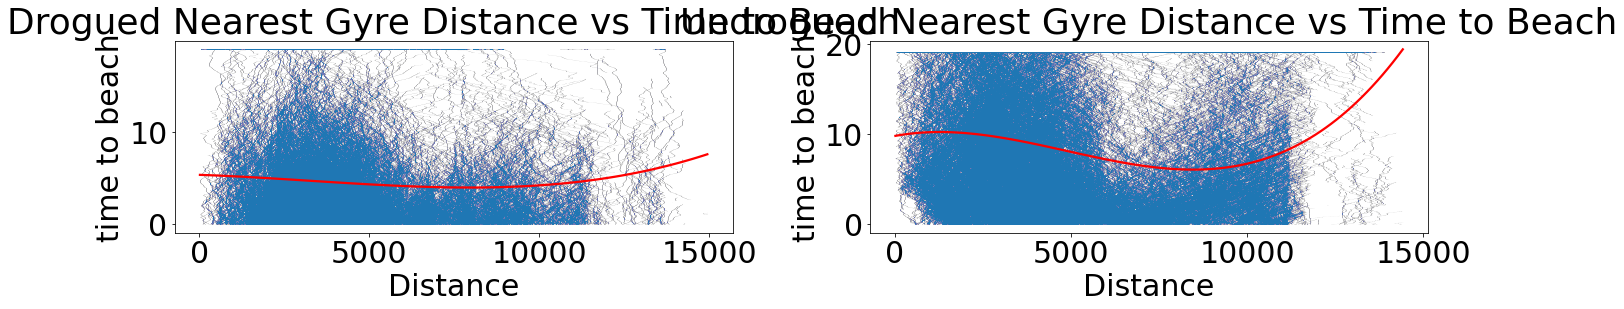

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.regplot(x='gyre distance', y='time to beach', data=beach_drogued, order = 3, ci=None, scatter_kws={"s":  0.000005},line_kws={"color": "red"}, ax = axs[0])
axs[0].set_xlabel('Distance')
axs[0].set_ylabel('time to beach')
axs[0].set_title('Drogued Nearest Gyre Distance vs Time to Beach')

sns.regplot(x='gyre distance', y='time to beach', data=beach_undrogued, order = 3, ci=None, scatter_kws={"s": 0.000005},line_kws={"color": "red"}, ax = axs[1])
axs[1].set_xlabel('Distance')
axs[1].set_ylabel('time to beach')
axs[1].set_title('Undrogued Nearest Gyre Distance vs Time to Beach')

plt.tight_layout()